In [7]:
import pandas as pd
import numpy as np

In [8]:
mean_1 = -3
std_1 = 2
num_samples_1 = 25

mean_2 = 3  
std_2 = 2
num_samples_2 = 15  

source_data = np.random.normal(mean_1, std_1, num_samples_1)

target_data = np.random.normal(mean_2, std_2, num_samples_2)


In [33]:
source_df = pd.DataFrame({'source': source_data})
target_df = pd.DataFrame({'target': target_data})

source_df.to_csv('Sdata.csv', index=False)
target_df.to_csv('Tdata.csv', index=False)

-2.7403359425648346
2.678558144242424


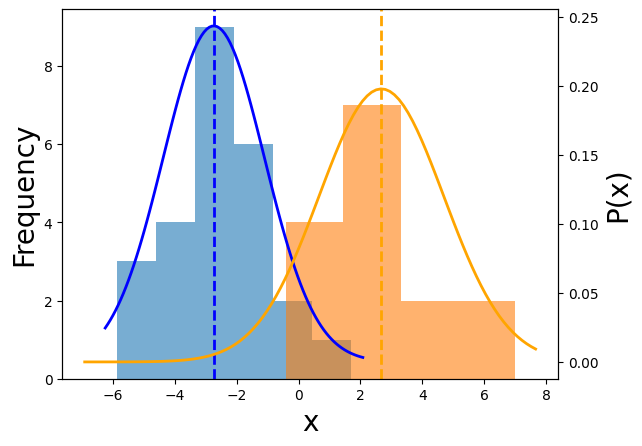

In [34]:
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm

fig, ax1 = plt.subplots()
ax2 = ax1.twinx() 

x = source_data
x2 = target_data

ax1.hist(x, bins=6,  alpha=0.6)
mu, sigma = norm.fit(x)
xmin, xmax = plt.xlim()
x_range = np.linspace(xmin, xmax, 100)
pdf = norm.pdf(x_range, mu, sigma)
ax2.plot(x_range, pdf, 'b', linewidth=2)
ax1.axvline(mu, color='b', linestyle='dashed', linewidth=2)
print(mu)
ax1.hist(x2, bins=4, alpha=0.6)
mu2, sigma2 = norm.fit(x2)
xmin2, xmax2 = plt.xlim()
x_range2 = np.linspace(xmin2, xmax2, 100)
pdf2 = norm.pdf(x_range2, mu2, sigma2)
ax2.plot(x_range2, pdf2, 'orange', linewidth=2)
ax1.axvline(mu2, color='orange', linestyle='dashed', linewidth=2)
print(mu2)

ax1.set_xlabel('x')
ax1.set_ylabel('Frequency')
ax2.set_ylabel('P(x)')
matplotlib.rc('axes', labelsize=20)
plt.savefig('Bin_distribution.png',bbox_inches = 'tight',dpi=600)
plt.savefig('Bin_distribution.svg',bbox_inches = 'tight',dpi=600)

# mapping the data

In [22]:
new_source, new_target = TCA(dim=1, lamda=1, gamma=2.5).fit(source_data.reshape(-1,1),target_data.reshape(-1,1))

In [32]:
TCA_source_df = pd.DataFrame(np.array(new_source))
TCA_target_df = pd.DataFrame(np.array(new_target))

TCA_source_df.to_csv('TCA_Sdata.csv', index=False)
TCA_target_df.to_csv('TCA_Tdata.csv', index=False)

0.00011988099725095792
0.00011988083787504879


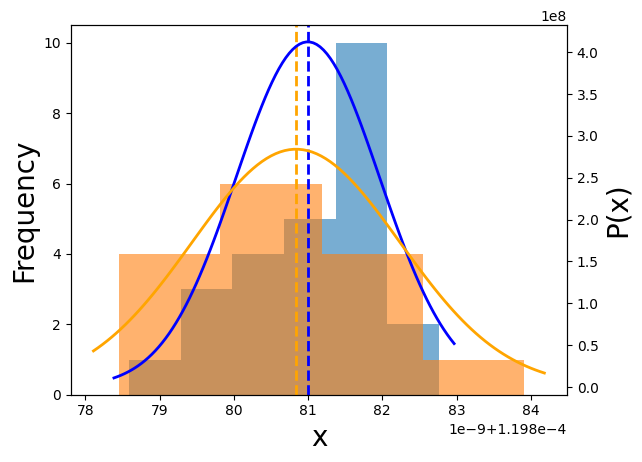

In [23]:
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm

fig, ax1 = plt.subplots()
ax2 = ax1.twinx() 

x = new_source 
x2 = new_target

ax1.hist(x, bins=6,  alpha=0.6)
mu, sigma = norm.fit(x)
xmin, xmax = plt.xlim()
x_range = np.linspace(xmin, xmax, 100)
pdf = norm.pdf(x_range, mu, sigma)
ax2.plot(x_range, pdf, 'b', linewidth=2)
ax1.axvline(mu, color='b', linestyle='dashed', linewidth=2)
print(mu)
ax1.hist(x2, bins=4, alpha=0.6)
mu2, sigma2 = norm.fit(x2)
xmin2, xmax2 = plt.xlim()
x_range2 = np.linspace(xmin2, xmax2, 100)
pdf2 = norm.pdf(x_range2, mu2, sigma2)
ax2.plot(x_range2, pdf2, 'orange', linewidth=2)
ax1.axvline(mu2, color='orange', linestyle='dashed', linewidth=2)
print(mu2)

ax1.set_xlabel('x')
ax1.set_ylabel('Frequency')
ax2.set_ylabel('P(x)')
matplotlib.rc('axes', labelsize=20)
plt.savefig('mapped_Bin_distribution.png',bbox_inches = 'tight',dpi=600)
plt.savefig('mapped_Bin_distribution.svg',bbox_inches = 'tight',dpi=600)

# TCA class

In [6]:
import numpy as np
import scipy.linalg
from sklearn.gaussian_process.kernels import  RBF 

class TCA():
    def __init__(self, dim=30, lamda=1, gamma=1):
        '''
        :param dim: data dimension after projection
        :param lamb: lambda value, Lagrange multiplier
        :param gamma: length scale for rbf kernel
        '''
        self.dim = dim
        self.lamda = lamda
        self.kernel = 0.5*RBF(gamma,"fixed")

    def fit(self, Xs, Xt, ):
        '''
        :param Xs: ns * m_feature, source domain data 
        :param Xt: nt * m_feature, target domain data
        Projecting Xs and Xt to a lower dimension by TCA
        source/target domain data expressed in a mapping space
        :return: Xs_new and Xt_new 
        '''
        # formular in paper Domain Adaptation via Transfer Component Analysis
        # Eq.(2) 
        X = np.vstack((Xs, Xt))
        K = self.kernel(X)
        # cal matrix L 
        ns, nt = len(Xs), len(Xt)
        if self.dim > (ns + nt):
            raise DimensionError('The maximum number of dimensions should be smaller than', (ns + nt))
        else:pass
        e = np.vstack((1 / ns * np.ones((ns, 1)), -1 / nt * np.ones((nt, 1))))
        L = e * e.T
        # cal centering matrix H page 202 the last pargraph at left side
        n, _ = X.shape
        H = np.eye(n) - 1 / n * np.ones((n, n))
        # page 202 the last pargraph at right side
        matrix = (K @ L @ K + self.lamda * np.eye(n)) @ K @ H @ K.T
        # cal eigenvalues : w, eigenvectors :V
        w, V = scipy.linalg.eig(matrix)
        w, V = w.real, V.real
        # peak out the first self.dim components
        ind = np.argsort(w)
        A = V[:, ind[:self.dim]]
        # output the mapped data
        Z = K @ A
        Xs_new, Xt_new = Z[:ns, :], Z[ns:, :]
        return Xs_new, Xt_new


class DimensionError(Exception):
    pass